# Apply Resolution Function to Simulation Data from LNGS

#### Iffat Zarif

### Import needed libraries

In [1]:
import numpy as np

import ROOT
from ROOT import *
import ctypes
from ctypes import *
from root_numpy import array2hist, hist2array, fill_hist

import sys
import math

import os
from scipy.optimize import *
import pandas as pd
# import seaborn as sns

from datetime import datetime
from glob import glob
from array import array

%cd Import_Data_Folder/
from dt5202 import dt5202_crunch # Import parser that Tom wrote. This is containted in the file 
                                 # named dt5202.py in the lib folder.
from dt5202oldDAQ import dt5202_crunch as dt5202_crunch_oldDAQ # Old ver

from langaus import LanGausFit 
%cd -

import warnings
warnings.filterwarnings("ignore")

Welcome to JupyROOT 6.24/02
/vast/palmer/home.grace/iz43/GammaBackgroundElimination_Iffat/Import_Data_Folder
/vast/palmer/home.grace/iz43/GammaBackgroundElimination_Iffat


### Declare constants

In [2]:
ped = 50 # Pedestal correction for dt5202

# Declare constants for conversion from ADC to PE/MeV
adc_mev = 538.3933387436877 # from "MuonPeakCalibration_Din_ThanksEmily_v1_cut.ipynb"
pe_mev = 53.95 # gotten from averaging two values from "OLD_MuonsAndGammas_SimulationFitting_Din_v2_w_Caesium.ipynb"

sig662 = 0.1601 # Get the sigma in [MeV] from "Cs137_GaussFitting_ForResolution_Din_vz1.ipynb"

hmin = 0.0 # Lower bound of full spectrum hist. (not simulating anything below 500 KeV) [MeV]
hmax = 15 # Upper bound of full spectrum hist. [MeV]
hspl = 2.8 # Approximate division point between gamma/muon spectra
R = 0.07
bins = int((hmax-hmin)/R) # Want the number of bins to be ~250

### Import simulated .root files and lab data

In [3]:
%%capture

%run /home/iz43/GammaBackgroundElimination_Iffat/Import_Data_Folder/Import_Simulated+Lab_Data_Iffat.ipynb # This notebook imports simulated data from LNGS

# Concatenate the energies into np arrays
g_mev_lab = np.concatenate((energyDeposited1460,energyDeposited2614,
                        energyDeposited1120,energyDeposited1238,
                        energyDeposited1764,energyDeposited2204,
                        energyDeposited968,energyDeposited934,
                        energyDeposited911,energyDeposited609,
                        energyDeposited583)) # individually simulated gamma lines, arrays declared in ext. notebook.
mu_mev_lab = np.array(muonsEnergy) # muons [MeV]
sim_mev_lab = np.concatenate((g_mev_lab, mu_mev_lab))
g_mev = np.array(gamma_spectrum)
mu_mev = np.array(muon_spectrum)
sim_mev = np.concatenate((g_mev, mu_mev)) # full spectrum [PE]

### Plot the Simulated Data

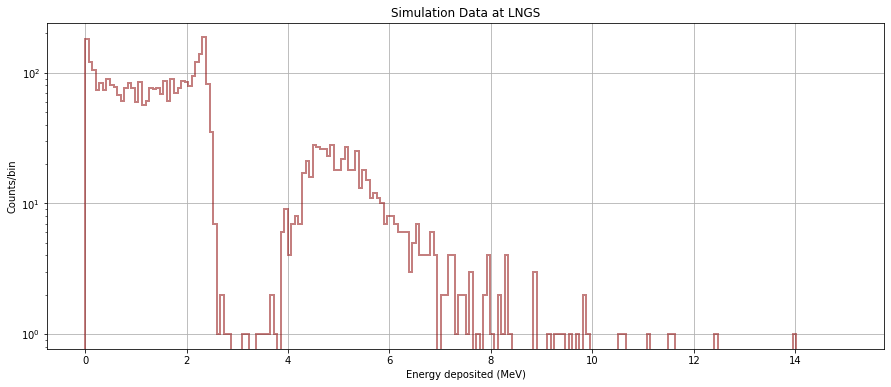

In [4]:
plt.figure(figsize=(15, 6))  
# Create histogram using numpy with transparent bars
counts, edges, _ = plt.hist(sim_mev, bins=bins, range=(hmin, hmax), edgecolor = "darkred", alpha=0.5, linewidth=2, histtype='step')

# Set up plot properties
plt.title("Simulation Data at LNGS")
plt.xlabel("Energy deposited (MeV)")
plt.ylabel("Counts/bin")
plt.yscale('log')  # Logarithmic scale on the y-axis
plt.grid(True)

plt.show()

### Plot Simulated LGNS Data Alongside imulated Lab Data and Actual Lab Data

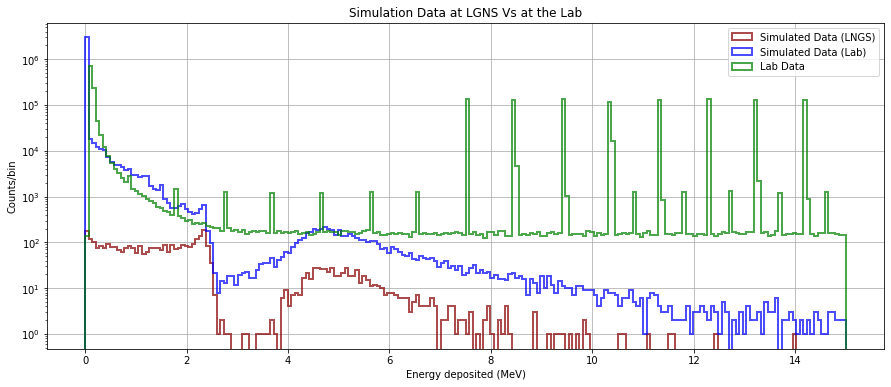

In [5]:

plt.figure(figsize=(15, 6)) 
# Create histograms using numpy
counts_sim, edges_sim, _ = plt.hist(sim_mev, bins=bins, range=(hmin, hmax), alpha=0.7, edgecolor='darkred', label='Simulated Data (LNGS)', histtype='step', linewidth=2)
counts_sim_lab, edges_sim_lab, _ = plt.hist(sim_mev_lab, bins=bins, range=(hmin, hmax), alpha=0.7, edgecolor='blue', label='Simulated Data (Lab)', histtype='step', linewidth=2)
counts_lab, edges_lab, _ = plt.hist(lab_mev, bins=bins, range=(hmin, hmax), alpha=0.7, edgecolor='green', label='Lab Data', histtype='step', linewidth=2)

# Set up plot properties
plt.title("Simulation Data at LGNS Vs at the Lab")
plt.xlabel("Energy deposited (MeV)")
plt.ylabel("Counts/bin")
plt.yscale('log')  # Logarithmic scale on the y-axis
plt.grid(True)
plt.legend()

plt.show()


## Apply System Response

### ATTEMPT 1: Constant sigma model


In [6]:
# Define the const. smearing function
# Takes in data in units of [MeV], output in [MeV]
def smear_const(dat_mev):
    dat_pe = dat_mev * pe_mev # Convert from [MeV] to [PE]
    dat_smeared = np.random.normal(loc=dat_pe, scale = sig662*pe_mev) # Has units [PE]
    dat_smeared = dat_smeared/pe_mev # Convert from [PE] to [MeV]
    return dat_smeared

### Plot with the constant sigma model

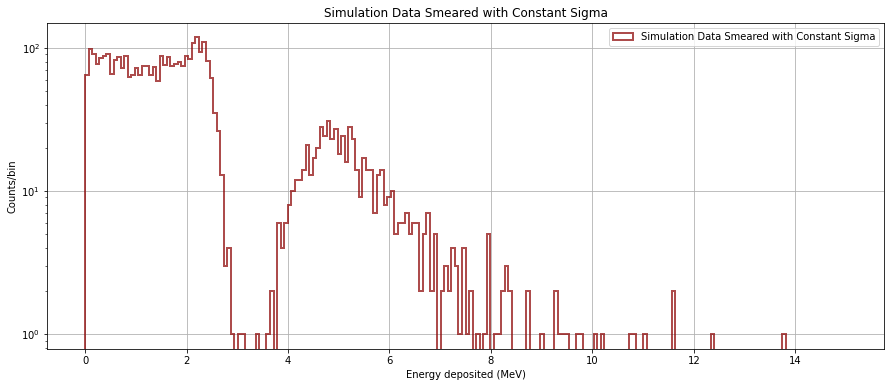

In [7]:
plt.figure(figsize=(15, 6)) 
# Create histogram using numpy 
#Apply the constant smearing function
counts, edges, _ = plt.hist(smear_const(sim_mev), bins=bins, range=(hmin, hmax), alpha=0.7, edgecolor='darkred', label='Simulation Data Smeared with Constant Sigma', linewidth=2, histtype = "step")

# Set up plot properties
plt.title("Simulation Data Smeared with Constant Sigma")
plt.xlabel("Energy deposited (MeV)")
plt.ylabel("Counts/bin")
plt.yscale('log')  # Logarithmic scale on the y-axis
plt.grid(True)
plt.legend()

plt.show()


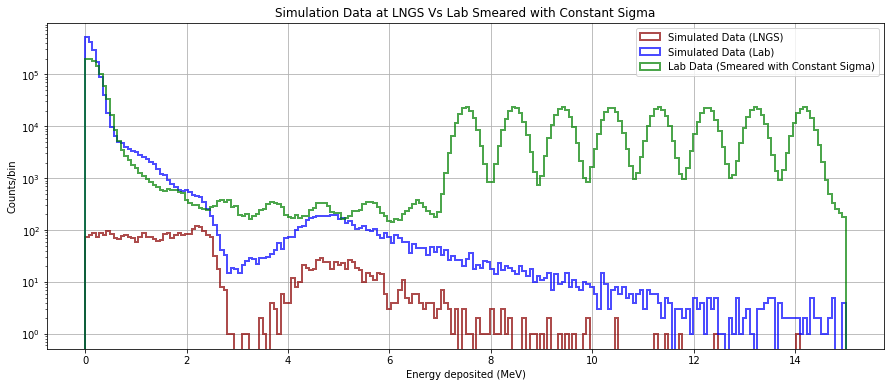

In [8]:
plt.figure(figsize=(15, 6)) 
# Create histograms using numpy
counts_sim, edges_sim, _ = plt.hist(smear_const(sim_mev), bins=bins, range=(hmin, hmax), alpha=0.7, edgecolor='darkred', label='Simulated Data (LNGS)', histtype = "step", linewidth = 2)
counts_sim_lab, edges_sim_lab, _ = plt.hist(smear_const(sim_mev_lab), bins=bins, range=(hmin, hmax), alpha=0.7, edgecolor='blue', label='Simulated Data (Lab)', histtype = "step", linewidth = 2)
counts_lab, edges_lab, _ = plt.hist(smear_const(lab_mev), bins=bins, range=(hmin, hmax), alpha=0.7, edgecolor='green', label='Lab Data (Smeared with Constant Sigma)', histtype = "step", linewidth = 2)

# Set up plot properties
plt.title("Simulation Data at LNGS Vs Lab Smeared with Constant Sigma")
plt.xlabel("Energy deposited (MeV)")
plt.ylabel("Counts/bin")
plt.yscale('log')  # Logarithmic scale on the y-axis
plt.grid(True)
plt.legend()

plt.show()

### ATTEMPT 2: Linear sigma model
$\sigma^2$ is attempted to be modeled using the assumption that is scales linearly with energy (in PE). By this assumption, the following mathematical relationship is used to extrapolate the value of $\sigma$ at 1 PE:

$$\sigma_{PE} = \frac{\sigma_{662\text{KeV}}}{0.662} E_{PE}$$

where $\sigma_{662\text{KeV}}$ is denoted by the previously-declared sig662 constant. Different smearing is applied to muons and gammas, the muons having an additional $x$-axis displacement of +16 PE. Moreover, because $\sigma^2$ is linear, the scale of the Normal distribution will take the form:

$$\text{scale} = a \sqrt{\sigma_{1\text{PE}} E_{PE}}$$

where $a$ is a scalar value.

In [9]:
sig1pe = (sig662*pe_mev) / (.662*pe_mev) # Assuming that sigma scales linearly, calculate its
                                         # value at 1 PE based on the value of sig662.

# Calculate the coefficient for the square root fn that will ensure sigma has value of sig662 at .662 KeV
# Denote this scalar by 'a'

a = (sig662*pe_mev) / np.sqrt(sig1pe*.662*pe_mev)

In [10]:
# Define the linear smearing function
# Takes in data in units of [MeV], x-axis shift in units of [PE], output in [MeV]
def smear_lin(dat_mev, dis_pe):
    dat_pe = dat_mev * pe_mev # Convert from [MeV] to [PE]
    dat_smeared = np.random.normal(loc=dat_pe, scale = a*np.power(sig1pe * dat_pe, 0.5)) + dis_pe # [PE]
    dat_smeared = dat_smeared/pe_mev # Convert from [PE] to [MeV]
    return dat_smeared

# Check if smearing gives correct value of sigma at 662 KeV.
print("Linearly scaled sigma model at 662 KeV: ", a*np.power(sig1pe * .331 * pe_mev, 0.5) / pe_mev)
print("Reference value: ", sig662)

Linearly scaled sigma model at 662 KeV:  0.11320779566796625
Reference value:  0.1601


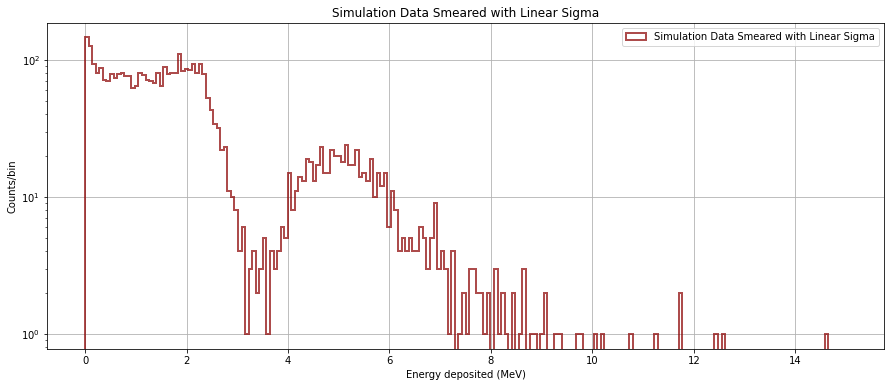

In [11]:
plt.figure(figsize=(15, 6)) 
# Create histogram using numpy
counts, edges, _ = plt.hist(smear_lin(sim_mev, 0), bins=bins, range=(hmin, hmax), alpha=0.7, edgecolor='darkred', label='Simulation Data Smeared with Linear Sigma', histtype = "step", linewidth = 2)

# Set up plot properties
plt.title("Simulation Data Smeared with Linear Sigma")
plt.xlabel("Energy deposited (MeV)")
plt.ylabel("Counts/bin")
plt.yscale('log')  # Logarithmic scale on the y-axis
plt.grid(True)
plt.legend()

plt.show()


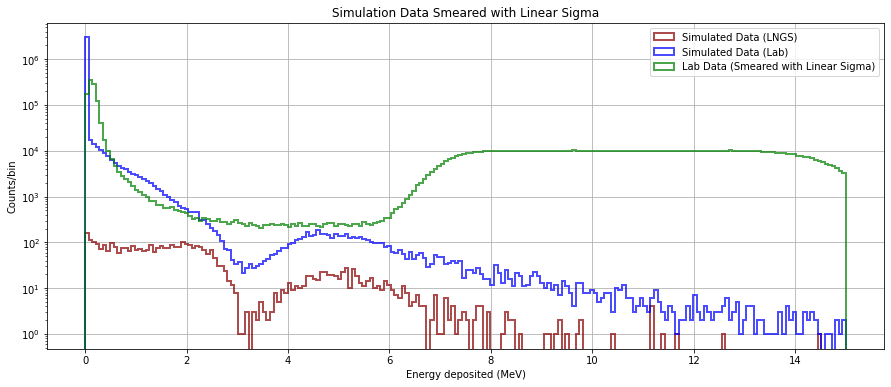

In [12]:
plt.figure(figsize=(15, 6))
# Create histograms using numpy
counts_sim, edges_sim, _ = plt.hist(smear_lin(sim_mev, 0), bins=bins, range=(hmin, hmax), alpha=0.7, edgecolor='darkred', label='Simulated Data (LNGS)', histtype = "step", linewidth = 2)
counts_sim_lab, edges_sim_lab, _ = plt.hist(smear_lin(sim_mev_lab, 0), bins=bins, range=(hmin, hmax), alpha=0.7, edgecolor='blue', label='Simulated Data (Lab)', histtype = "step", linewidth = 2)
counts_lab, edges_lab, _ = plt.hist(smear_lin(lab_mev, 0), bins=bins, range=(hmin, hmax), alpha=0.7, edgecolor='green', label='Lab Data (Smeared with Linear Sigma)', histtype = "step", linewidth = 2)

# Set up plot properties
plt.title("Simulation Data Smeared with Linear Sigma")
plt.xlabel("Energy deposited (MeV)")
plt.ylabel("Counts/bin")
plt.yscale('log')  # Logarithmic scale on the y-axis
plt.grid(True)
plt.legend()

plt.show()

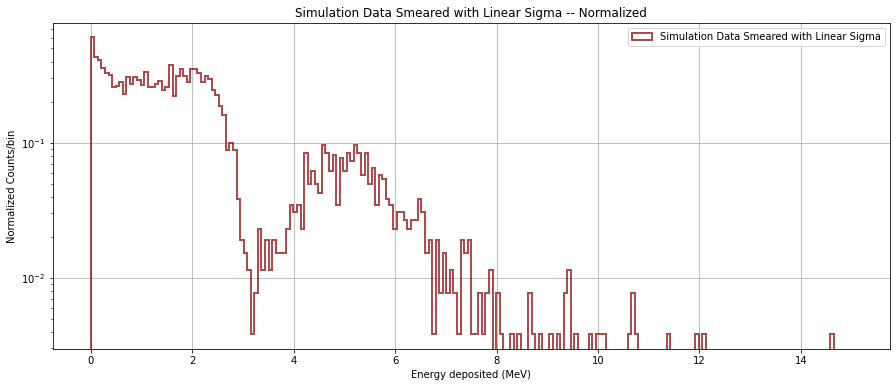

In [13]:
lx = int(0.1/R) # [MeV]
ux = int(2.6/R) # [MeV]
plt.figure(figsize=(15, 6)) 
norm_counts, norm_edges, _ = plt.hist(smear_lin(sim_mev, 0), bins=bins, range=(hmin, hmax), alpha=0.7, edgecolor='darkred', label='Simulation Data Smeared with Linear Sigma', density = True, histtype = "step", linewidth = 2)

# Set up plot properties
plt.title("Simulation Data Smeared with Linear Sigma -- Normalized")
plt.xlabel("Energy deposited (MeV)")
plt.ylabel("Normalized Counts/bin")
plt.yscale('log')  # Logarithmic scale on the y-axis
plt.grid(True)
plt.legend()

plt.show()

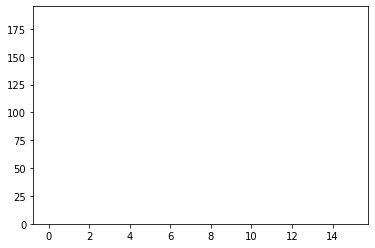

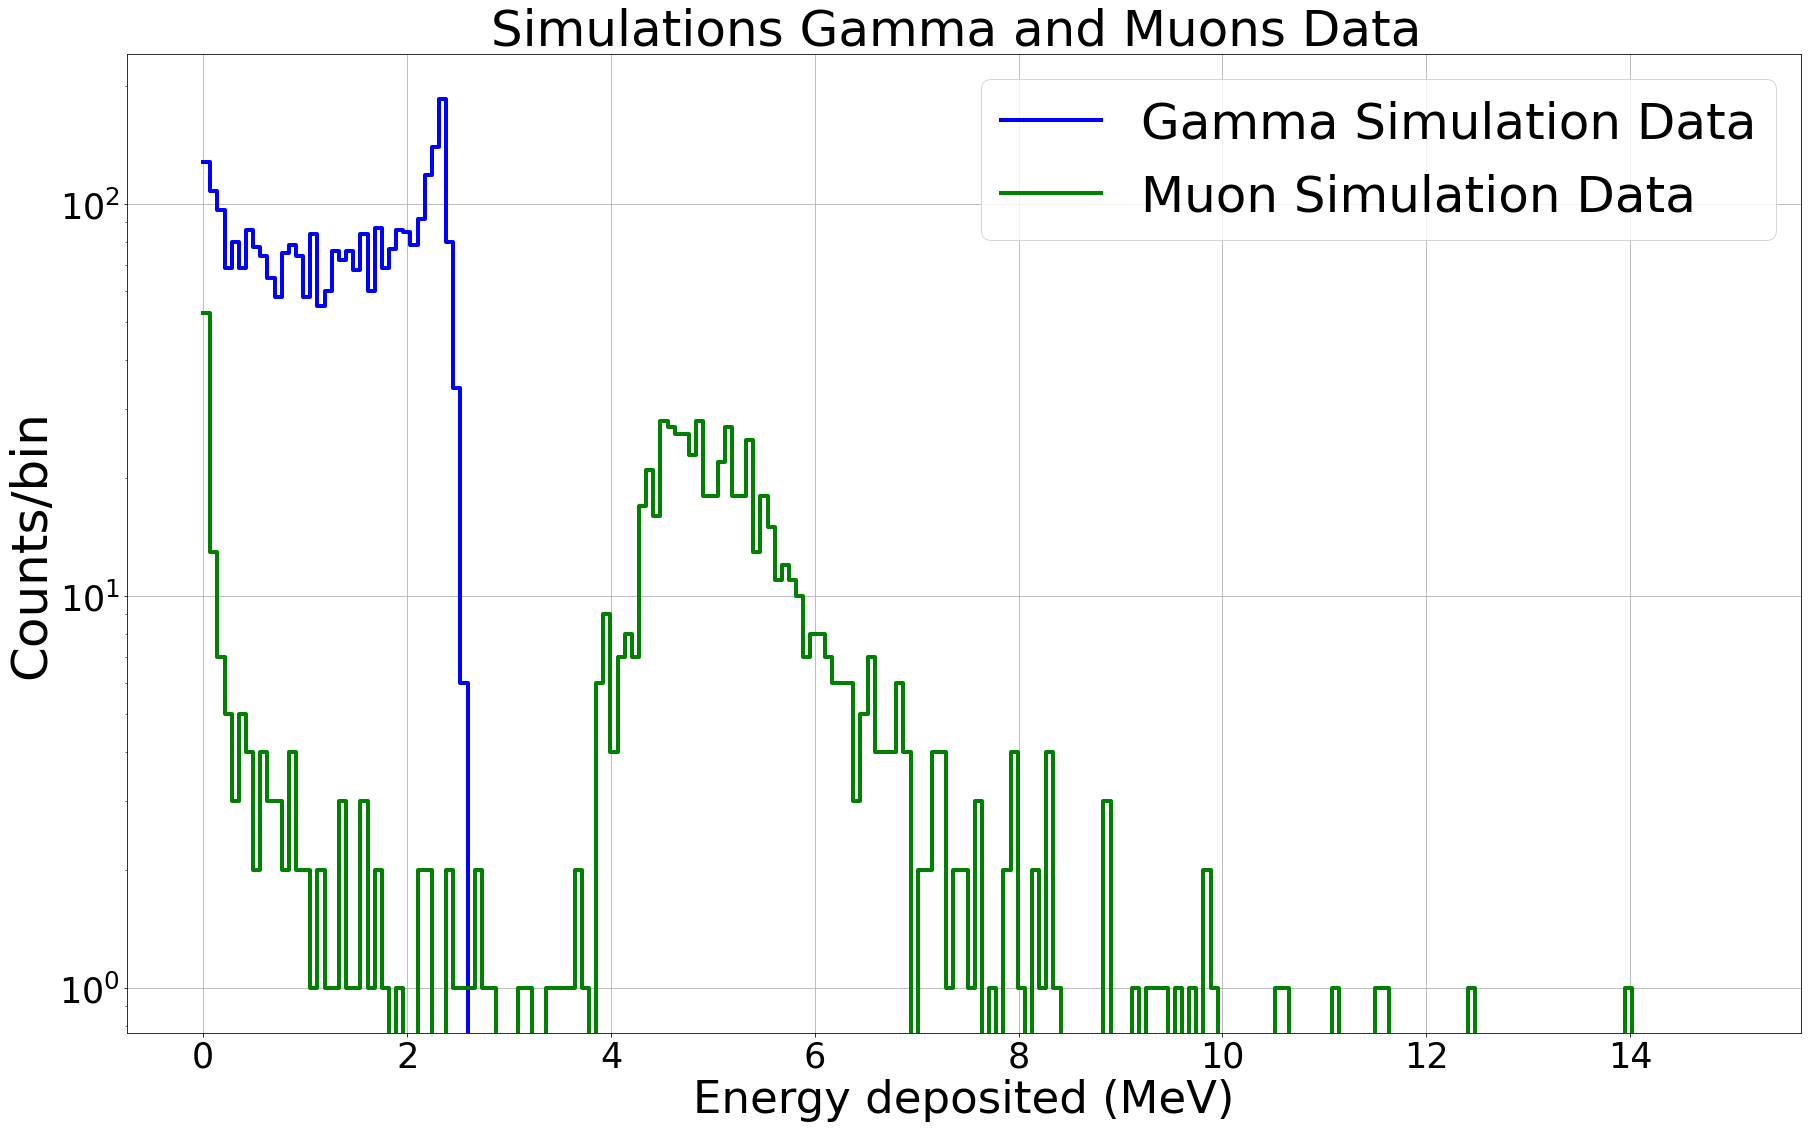

In [14]:
counts_g, edges_g, _ = plt.hist(g_mev, bins=bins, range=(hmin, hmax), alpha=0.0, edgecolor='blue', label='Gamma Simulation Data Smeared with Linear Sigma', histtype = "step")
counts_mu, edges_mu, _ = plt.hist(mu_mev, bins=bins, range=(hmin, hmax), alpha=0.0, edgecolor='green', label='Muon Simulation Data Smeared with Linear Sigma', histtype = "step")
 
plt.figure(figsize=(30, 18)) 
plt.step(edges_g[:-1], counts_g, where='post', color='blue', linewidth = 4.0, label='Gamma Simulation Data')
plt.step(edges_mu[:-1], counts_mu, where='post', color='green', linewidth = 4.0, label='Muon Simulation Data')

# Set up plot properties
plt.title("Simulations Gamma and Muons Data ", fontsize=50)
plt.xlabel("Energy deposited (MeV)", fontsize=45)
plt.ylabel("Counts/bin", fontsize=50)
plt.yscale('log')  # Logarithmic scale on the y-axis
plt.grid(True)
plt.legend(fontsize=50)
plt.xticks(fontsize=35)  # Adjust the fontsize as needed
plt.yticks(fontsize=35)


plt.show()


### Smear and Normalize Muon and Gamma Data Separately

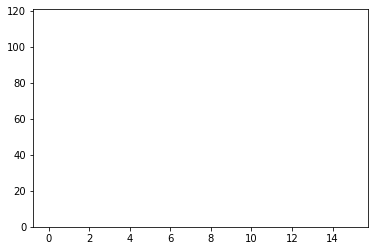

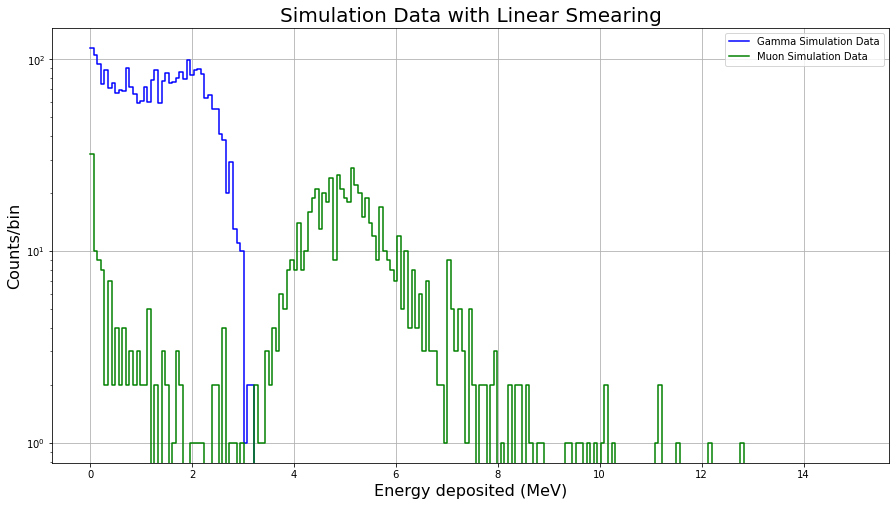

In [15]:
lin_counts_g, edges_g, _ = plt.hist(smear_lin(g_mev, 0), bins=bins, range=(hmin, hmax), alpha=0.0, edgecolor='blue', label='Gamma Simulation Data Smeared with Linear Sigma', histtype = "step", linewidth = 2)
lin_counts_mu, edges_mu, _ = plt.hist(smear_lin(mu_mev, 0), bins=bins, range=(hmin, hmax), alpha=0.0, edgecolor='green', label='Muon Simulation Data Smeared with Linear Sigma', histtype = "step", linewidth = 2)

plt.figure(figsize=(15, 8)) 
plt.step(edges_g[:-1], lin_counts_g, where='post', color='blue', label='Gamma Simulation Data')
plt.step(edges_mu[:-1], lin_counts_mu, where='post', color='green', label='Muon Simulation Data')

# Set up plot properties
plt.title("Simulation Data with Linear Smearing", fontsize=20)
plt.xlabel("Energy deposited (MeV)", fontsize=16)
plt.ylabel("Counts/bin", fontsize=16)
plt.yscale('log')  # Logarithmic scale on the y-axis
plt.grid(True)
plt.legend()

plt.show()



### Normalize the smeared muon and gamma data

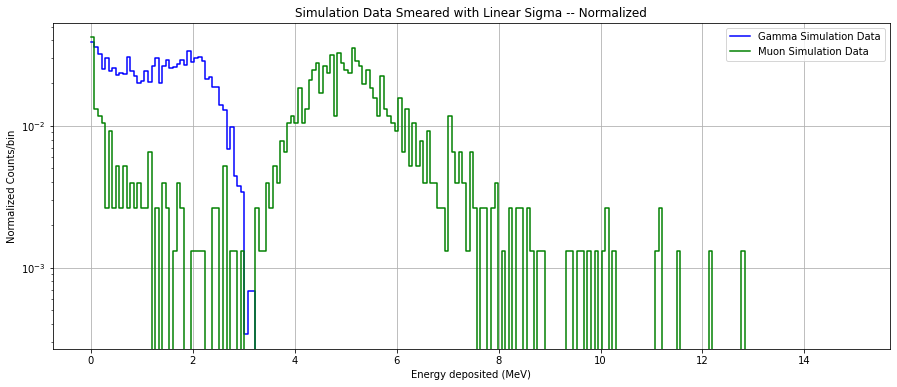

In [16]:
norm_counts_g = lin_counts_g/np.sum(lin_counts_g)
norm_counts_mu = lin_counts_mu/np.sum(lin_counts_mu)
norm_edges_g = edges_g
norm_edges_mu = edges_mu
plt.figure(figsize=(15, 6)) 
plt.step(norm_edges_g[:-1], norm_counts_g, where='post', color='blue', label='Gamma Simulation Data')
plt.step(norm_edges_mu[:-1], norm_counts_mu, where='post', color='green', label='Muon Simulation Data')

# Set up plot properties
plt.title("Simulation Data Smeared with Linear Sigma -- Normalized")
plt.xlabel("Energy deposited (MeV)")
plt.ylabel("Normalized Counts/bin")
plt.yscale('log')  # Logarithmic scale on the y-axis
plt.grid(True)
plt.legend()

plt.show()

### Cumulative Density Graphs for Gamma and Muons

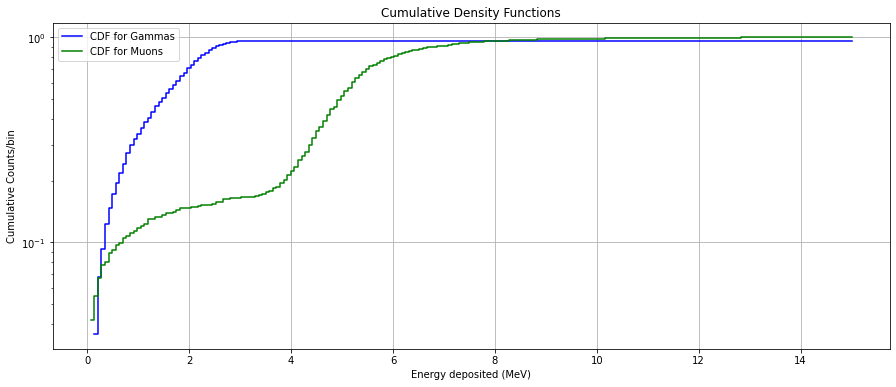

In [17]:
thresholds_g = norm_edges_g[1:]
thresholds_mu = norm_edges_mu[1:]
cumulative_g = np.cumsum(norm_counts_g[1:])
cumulative_mu = np.cumsum(norm_counts_mu)

plt.figure(figsize=(15, 6)) 
plt.step(thresholds_g[1:], cumulative_g, where='post', color='blue', label='CDF for Gammas')
plt.step(thresholds_mu, cumulative_mu, where='post', color='green', label='CDF for Muons')

plt.title("Cumulative Density Functions")
plt.xlabel("Energy deposited (MeV)")
plt.ylabel("Cumulative Counts/bin")
plt.yscale('log')  # Logarithmic scale on the y-axis
plt.grid(True)
plt.legend()


plt.show()

### Finding the Threshold Energy where Gamma Counts go to Zero

In [18]:
max_g = max(cumulative_g)
max_index_g = np.argmax(cumulative_g)
print("Index of maximum gamma value: " + str(max_index_g))
gamma_zero_threshold = thresholds_g[max_index_g]
print("Energy at which gamma counts go to zero: " + str(gamma_zero_threshold))

Index of maximum gamma value: 44
Energy at which gamma counts go to zero: 3.1542056074766354


### Drawing the Probabiltiy Density Function Over the Gamma-Zero Threshold

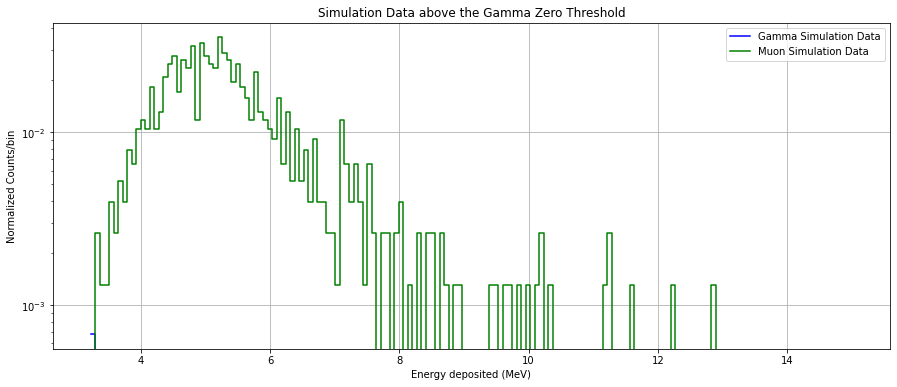

In [19]:
plt.figure(figsize=(15, 6)) 
plt.step(thresholds_g[max_index_g+1:], norm_counts_g[max_index_g+1:], where='post', color='blue', label='Gamma Simulation Data')
plt.step(thresholds_mu[max_index_g+1:], norm_counts_mu[max_index_g+1:], where='post', color='green', label='Muon Simulation Data')
# Set up plot properties
plt.title("Simulation Data above the Gamma Zero Threshold")
plt.xlabel("Energy deposited (MeV)")
plt.ylabel("Normalized Counts/bin")
plt.yscale('log')  # Logarithmic scale on the y-axis
plt.grid(True)
plt.legend()

plt.show()

### Varying Energy Threshold to Find Optimum

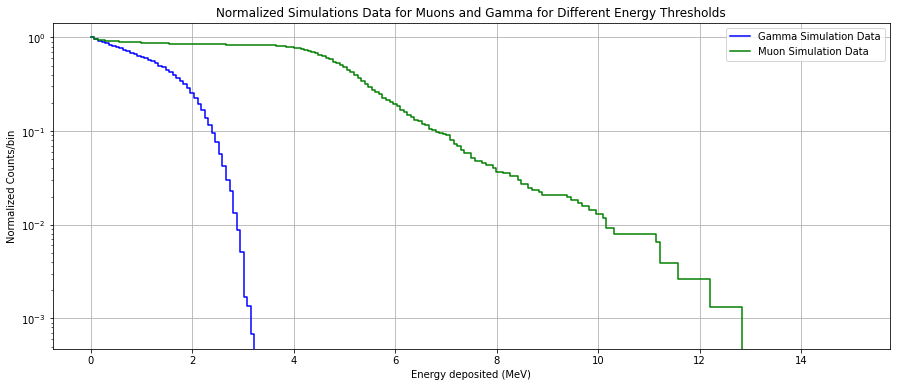

In [20]:
plt.figure(figsize=(15, 6))
cum_g = np.array([])
cum_mu = np.array([])
for t in range(len(norm_edges)):
    cum_g = np.append(cum_g, sum(norm_counts_g[t:]))
    cum_mu = np.append(cum_mu, sum(norm_counts_mu[t:]))

plt.step(norm_edges, cum_g, where='post', color='blue', label='Gamma Simulation Data')
plt.step(norm_edges, cum_mu, where='post', color='green', label='Muon Simulation Data')

# Set up plot properties
plt.title("Normalized Simulations Data for Muons and Gamma for Different Energy Thresholds")
plt.xlabel("Energy deposited (MeV)")
plt.ylabel("Normalized Counts/bin")
plt.yscale('log')  # Logarithmic scale on the y-axis
plt.grid(True)
plt.legend()

plt.show()

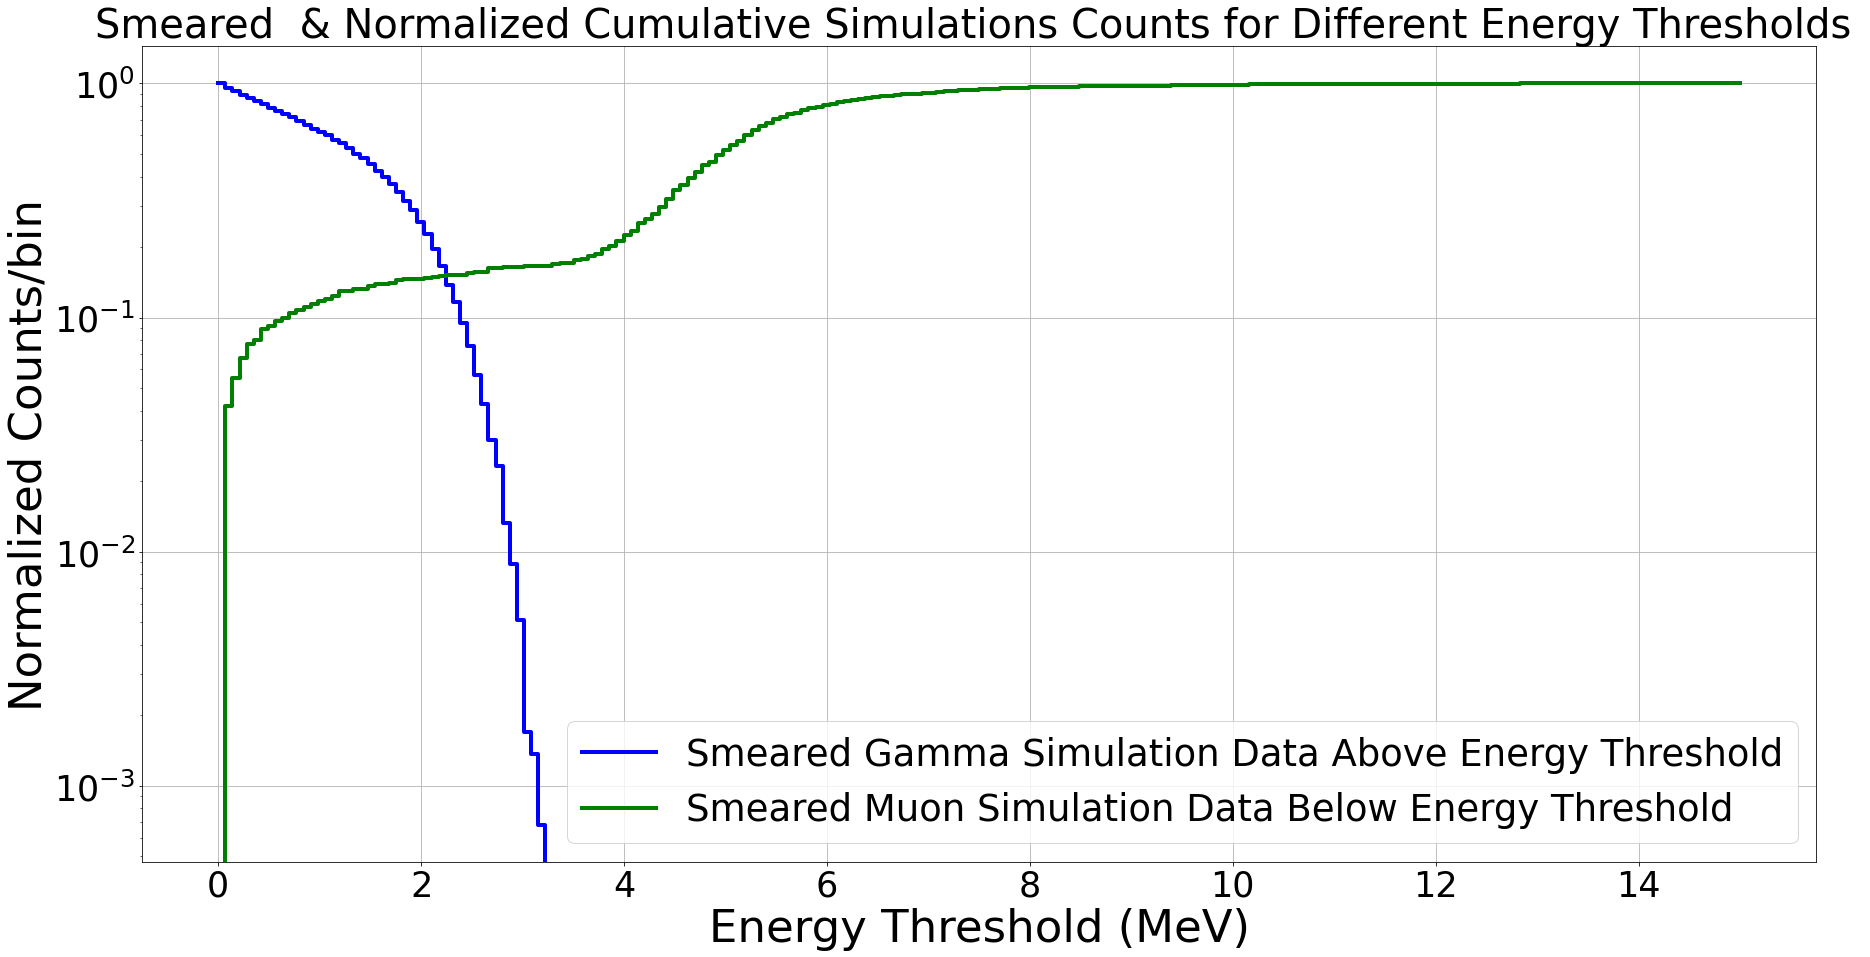

The Optimum Energy: 2.2429906542056073


In [21]:
plt.figure(figsize=(30, 15))
cum_g = np.array([])
cum_mu = np.array([])
norm_cum_g = np.array([])
norm_cum_mu = np.array([])
for t in range(len(norm_edges)):
    norm_cum_g = np.append(norm_cum_g, sum(norm_counts_g[t:]))
    norm_cum_mu = np.append(norm_cum_mu, sum(norm_counts_mu[:t]))
    cum_g = np.append(cum_g, sum(counts_g[t:]))
    cum_mu = np.append(cum_mu, sum(counts_mu[:t]))

plt.step(norm_edges, norm_cum_g, where='post', color='blue', linewidth = 4.0, label='Smeared Gamma Simulation Data Above Energy Threshold')
plt.step(norm_edges, norm_cum_mu, where='post', color='green',linewidth = 4.0, label='Smeared Muon Simulation Data Below Energy Threshold')

#plt.step(norm_edges, cum_g/np.sum(counts_g), where='post', linestyle='--', color='purple', label='Gamma Simulation Data Above Energy Threshold')
#plt.step(norm_edges, cum_mu/np.sum(counts_mu), where='post', color='teal', linestyle='--', label='Muon Simulation Data Below Energy Threshold')
# Set up plot properties
plt.title("Smeared  & Normalized Cumulative Simulations Counts for Different Energy Thresholds ", fontsize=40)
plt.xlabel("Energy Threshold (MeV)", fontsize=45)
plt.ylabel("Normalized Counts/bin", fontsize=45)
plt.yscale('log')  # Logarithmic scale on the y-axis
plt.grid(True)
plt.xticks(fontsize=35)  # Adjust the fontsize as needed
plt.yticks(fontsize=35)

# Find the crossing point
crossing_index = np.argmax(norm_cum_g <= norm_cum_mu)
crossing_point = norm_edges[crossing_index]

# Plot the crossing point

plt.legend(fontsize=37)


plt.show()
print("The Optimum Energy: "+str(crossing_point))

### Converting to Rate (With Smearing)


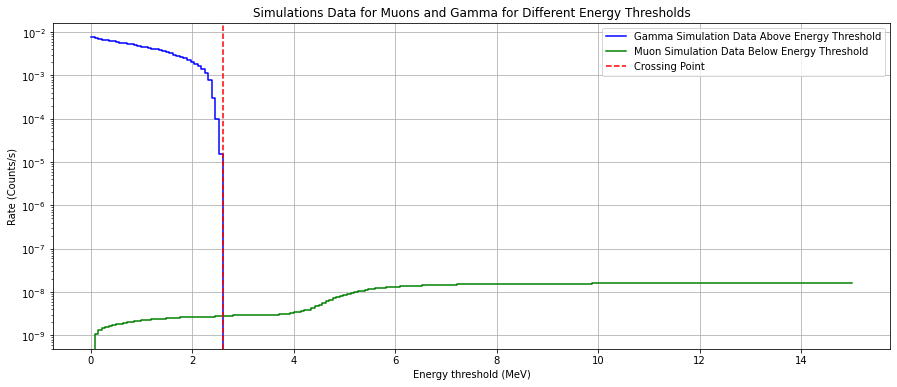

The Optimum Energy: 2.5934579439252334


In [22]:
plt.figure(figsize=(15, 6))
rate_g = 0.015*0.5
rate_mu = 3.2*10**(-8)*0.5
time_g = sum(counts_g)/rate_g
time_mu = sum(counts_mu)/rate_mu
rate_g = np.array([])
rate_mu = np.array([])
edges_g = np.array([])
for t in range(len(edges)):
        edges_g = np.append(edges_g, edges[t])
        rate_g = np.append(rate_g, sum(counts_g[t:])/time_g)
        rate_mu = np.append(rate_mu, sum(counts_mu[:t]/time_mu))
plt.step(edges_g, rate_g, where='post', color='blue', label='Gamma Simulation Data Above Energy Threshold')
plt.step(edges_g, rate_mu, where='post', color='green', label='Muon Simulation Data Below Energy Threshold')

# Set up plot properties
plt.title("Simulations Data for Muons and Gamma for Different Energy Thresholds")
plt.xlabel("Energy threshold (MeV)")
plt.ylabel("Rate (Counts/s)")
plt.yscale('log')  # Logarithmic scale on the y-axis
plt.grid(True)

# Find the crossing point
crossing_index = np.argmax(rate_g <= rate_mu)
crossing_point = norm_edges[crossing_index]

# Plot the crossing point
plt.axvline(x=crossing_point, color='red', linestyle='--', label='Crossing Point')
plt.legend()

plt.show()
print("The Optimum Energy: "+str(crossing_point))

### False Positive Rate (FPR)



(array([1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

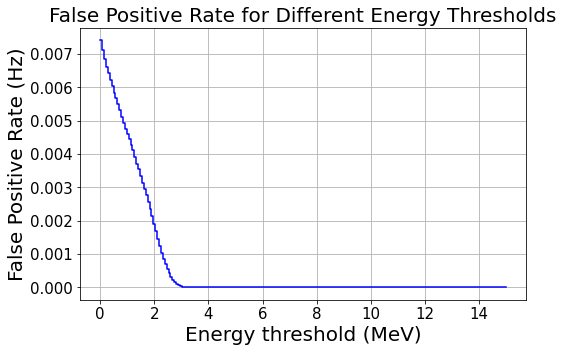

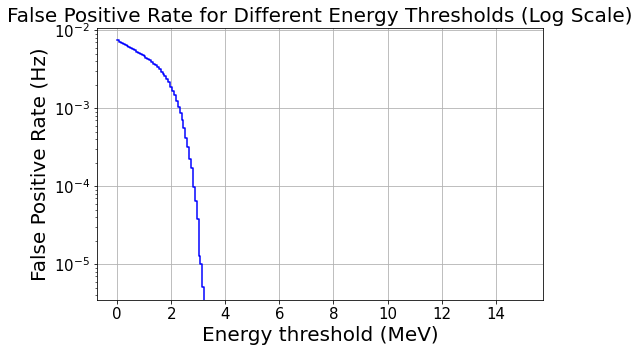

In [23]:
fpr = np.array([])
for t in range(len(edges)):
        fpr = np.append(fpr, sum(lin_counts_g[t:])/time_g)
plt.figure(figsize=(8, 5))
plt.step(edges, fpr, where='post', color='blue', label='Gamma Simulation Data Above Energy Threshold')
plt.title("False Positive Rate for Different Energy Thresholds", fontsize = 20)
plt.xlabel("Energy threshold (MeV)", fontsize = 20)
plt.ylabel("False Positive Rate (Hz)", fontsize = 20)
#plt.yscale('log')  # Logarithmic scale on the y-axis
plt.grid(True)
plt.xticks(fontsize=15)  # Adjust the fontsize as needed
plt.yticks(fontsize=15)


plt.figure(figsize=(8, 5))
plt.step(edges, fpr, where='post', color='blue', label='Gamma Simulation Data Above Energy Threshold')
plt.title("False Positive Rate for Different Energy Thresholds (Log Scale)", fontsize = 20)
plt.xlabel("Energy threshold (MeV)", fontsize = 20)
plt.ylabel("False Positive Rate (Hz)", fontsize = 20)
plt.yscale('log')  # Logarithmic scale on the y-axis
plt.grid(True)
plt.xticks(fontsize=15)  # Adjust the fontsize as needed
plt.yticks(fontsize=15)


### Muon Rate


(array([1.e-12, 1.e-11, 1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

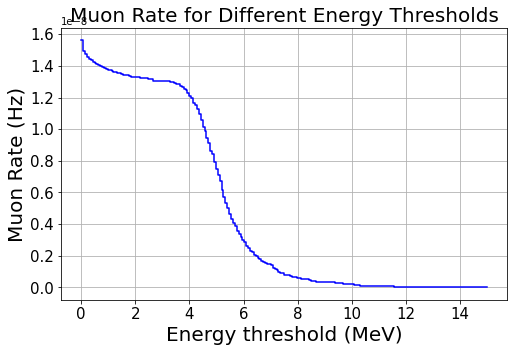

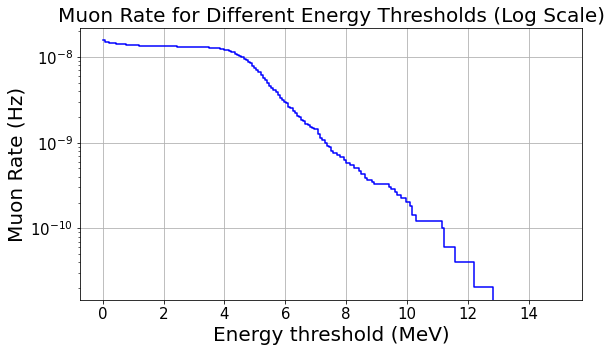

In [24]:
mu_rate = np.array([])
for t in range(len(edges)):
        mu_rate = np.append(mu_rate, sum(lin_counts_mu[t:])/time_mu)

plt.figure(figsize=(8, 5))
plt.step(edges, mu_rate, where='post', color='blue', label='Muon Simulation Data Above Energy Threshold')
plt.title("Muon Rate for Different Energy Thresholds", fontsize = 20)
plt.xlabel("Energy threshold (MeV)", fontsize = 20)
plt.ylabel("Muon Rate (Hz)", fontsize = 20)
plt.grid(True)
plt.xticks(fontsize=15)  # Adjust the fontsize as needed
plt.yticks(fontsize=15)


plt.figure(figsize=(9, 5))
plt.step(edges, mu_rate, where='post', color='blue', label='Muon Simulation Data Above Energy Threshold')
plt.title("Muon Rate for Different Energy Thresholds (Log Scale)", fontsize = 20)
plt.xlabel("Energy threshold (MeV)", fontsize = 20)
plt.ylabel("Muon Rate (Hz)", fontsize = 20)
plt.yscale('log')  # Logarithmic scale on the y-axis
plt.grid(True)
plt.xticks(fontsize=15)  # Adjust the fontsize as needed
plt.yticks(fontsize=15)

### Fpr & Muon Rate Together


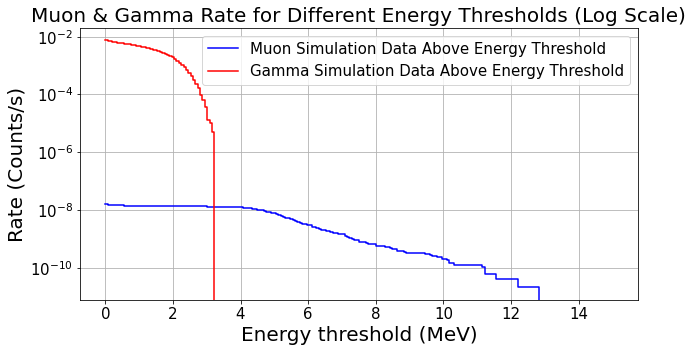

In [25]:
#The Raw Scale is not even visible

plt.figure(figsize=(10, 5))
plt.step(edges, mu_rate, where='post', color='blue', label='Muon Simulation Data Above Energy Threshold')
plt.step(edges, fpr, where='post', color='red', label='Gamma Simulation Data Above Energy Threshold')
plt.title("Muon & Gamma Rate for Different Energy Thresholds (Log Scale)", fontsize = 20)
plt.xlabel("Energy threshold (MeV)", fontsize = 20)
plt.ylabel("Rate (Counts/s)", fontsize = 20)
plt.yscale('log')  # Logarithmic scale on the y-axis
plt.grid(True)
plt.xticks(fontsize=15)  # Adjust the fontsize as needed
plt.yticks(fontsize=15)

plt.legend(fontsize=15)

### Muon Efficiency

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

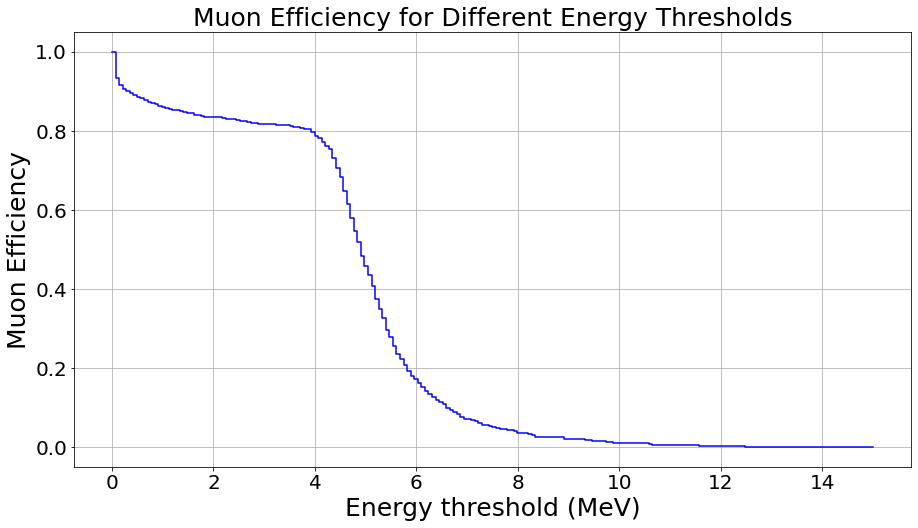

In [26]:
plt.figure(figsize=(15, 8))
mu_eff = np.array([])
for t in range(len(edges)):
        mu_eff = np.append(mu_eff, sum(counts_mu[t:])/sum(counts_mu))
plt.step(edges, mu_eff, where='post', color='blue')
plt.title("Muon Efficiency for Different Energy Thresholds", fontsize = 25)
plt.xlabel("Energy threshold (MeV)", fontsize = 25)
plt.ylabel("Muon Efficiency", fontsize = 25)
#plt.yscale('log')  # Logarithmic scale on the y-axis
plt.grid(True)
plt.xticks(fontsize=20)  # Adjust the fontsize as needed
plt.yticks(fontsize=20)

### Gamma Leftover 

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

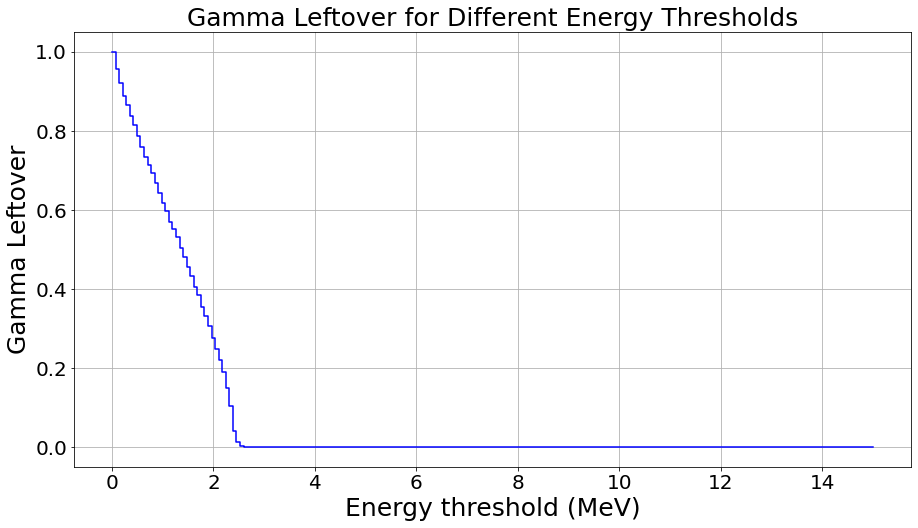

In [27]:
plt.figure(figsize=(15, 8))
g_left = np.array([])
for t in range(len(edges)):
        g_left = np.append(g_left, sum(counts_g[t:])/sum(counts_g))
plt.step(edges, g_left, where='post', color='blue')
plt.title("Gamma Leftover for Different Energy Thresholds", fontsize = 25)
plt.xlabel("Energy threshold (MeV)", fontsize = 25)
plt.ylabel("Gamma Leftover", fontsize = 25)
#plt.yscale('log')  # Logarithmic scale on the y-axis
plt.grid(True)
plt.xticks(fontsize=20)  # Adjust the fontsize as needed
plt.yticks(fontsize=20)

### Gamma Leftover & Muon Efficiency Comparison


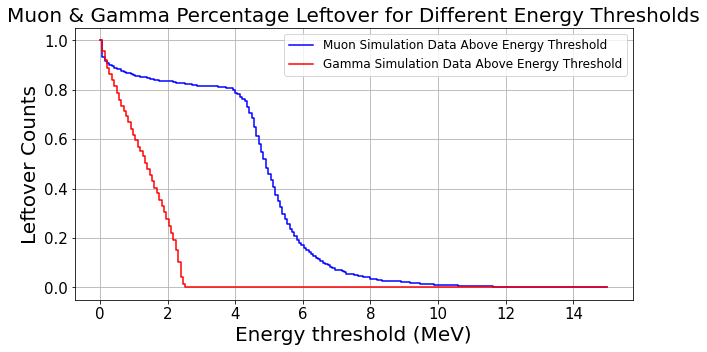

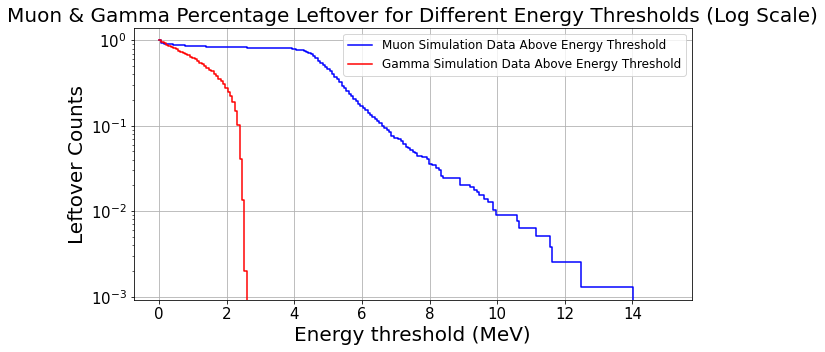

In [28]:
plt.figure(figsize=(10, 5))
plt.step(edges, mu_eff, where='post', color='blue', label='Muon Simulation Data Above Energy Threshold')
plt.step(edges, g_left, where='post', color='red', label='Gamma Simulation Data Above Energy Threshold')
plt.title("Muon & Gamma Percentage Leftover for Different Energy Thresholds", fontsize = 20)
plt.xlabel("Energy threshold (MeV)", fontsize = 20)
plt.ylabel("Leftover Counts", fontsize = 20)
plt.grid(True)
plt.xticks(fontsize=15)  # Adjust the fontsize as needed
plt.yticks(fontsize=15)

plt.legend(fontsize=12)

plt.figure(figsize=(10, 5))
plt.step(edges, mu_eff, where='post', color='blue', label='Muon Simulation Data Above Energy Threshold')
plt.step(edges, g_left, where='post', color='red', label='Gamma Simulation Data Above Energy Threshold')
plt.title("Muon & Gamma Percentage Leftover for Different Energy Thresholds (Log Scale)", fontsize = 20)
plt.xlabel("Energy threshold (MeV)", fontsize = 20)
plt.ylabel("Leftover Counts", fontsize = 20)
plt.yscale('log')  # Logarithmic scale on the y-axis
plt.grid(True)
plt.xticks(fontsize=15)  # Adjust the fontsize as needed
plt.yticks(fontsize=15)

plt.legend(fontsize=12)